<a href="https://colab.research.google.com/github/Danila565/Diploma/blob/main/Diploma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
!pip install navec
!pip install pymorphy2
!pip install keras_preprocessing

In [ ]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Embedding, GlobalMaxPooling1D, LSTM
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from navec import Navec
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical

In [ ]:
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
import re

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
navec_model  = Navec.load('/content/drive/MyDrive/Диплом/navec_hudlit_v1_12B_500K_300d_100q.tar')

In [ ]:
# Load the data
df = pd.read_csv("/content/drive/MyDrive/Диплом/90000_preprocess.csv")

In [ ]:
import matplotlib.pyplot as plt

# создаем список длин строк из столбца dataframe
string_lengths = [len(i) for i in df['preprocess']]

In [ ]:
len(string_lengths)

90164

In [ ]:
cnt = 0
for i in string_lengths:
  if i <= 400:
    cnt += 1
print(cnt / 90164)

0.9943325495763276


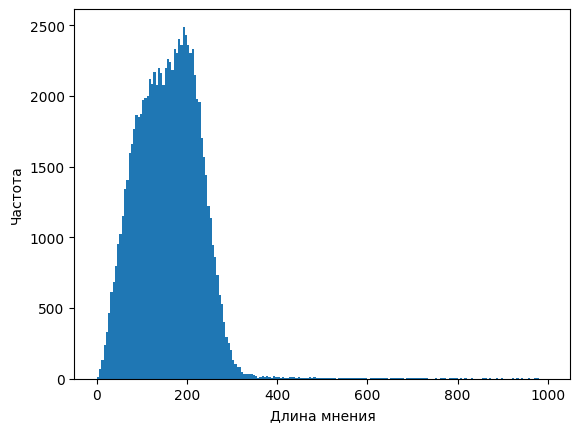

In [ ]:
# строим гистограмму
plt.hist(string_lengths, bins=200, range=(0,1000))
plt.xlabel('Длина мнения')
plt.ylabel('Частота')
plt.show()

In [ ]:
# Preprocess the text data
tokenizer = Tokenizer(num_words=70000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['preprocess'])
sequences = tokenizer.texts_to_sequences(df['preprocess'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
max_len = 400
data = pad_sequences(sequences, maxlen=max_len)
y = to_categorical(df['label'])

Found 101741 unique tokens.


In [ ]:
# Convert the embeddings to a matrix
embedding_dim = 300
num_words = min(70000, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = navec_model.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, df['label'], test_size=0.2, random_state=42)

In [ ]:
# One-hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
y_test.sum(axis=0)

array([3281., 2505., 3231.], dtype=float32)

In [ ]:
!pip install tensorflow_addons

In [ ]:
import tensorflow_addons as tfa

In [ ]:
# Define the model architecture
model = Sequential()
model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))
model.add(Dropout(0.3))
model.add(Conv1D(400, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.3))
model.add(Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy(name='cat_accuracy'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision'), tfa.metrics.F1Score(name='f1-score', num_classes=3)])

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=96)

Epoch 1/10
752/752 [==============================] - 70s 91ms/step - loss: 1.3556 - cat_accuracy: 0.5795 - recall: 0.4095 - precision: 0.6812 - f1-score: 0.5737 - val_loss: 1.0071 - val_cat_accuracy: 0.6959 - val_recall: 0.6248 - val_precision: 0.7403 - val_f1-score: 0.6943
Epoch 2/10
752/752 [==============================] - 40s 53ms/step - loss: 0.9051 - cat_accuracy: 0.7173 - recall: 0.6550 - precision: 0.7609 - f1-score: 0.7142 - val_loss: 0.8101 - val_cat_accuracy: 0.7415 - val_recall: 0.6964 - val_precision: 0.7739 - val_f1-score: 0.7403
Epoch 3/10
752/752 [==============================] - 39s 52ms/step - loss: 0.7118 - cat_accuracy: 0.7859 - recall: 0.7472 - precision: 0.8164 - f1-score: 0.7846 - val_loss: 0.6862 - val_cat_accuracy: 0.7928 - val_recall: 0.7539 - val_precision: 0.8256 - val_f1-score: 0.7924
Epoch 4/10
752/752 [==============================] - 36s 48ms/step - loss: 0.5615 - cat_accuracy: 0.8467 - recall: 0.8242 - precision: 0.8668 - f1-score: 0.8466 - val_loss

In [ ]:
model.save('/content/drive/MyDrive/Диплом/model5')

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
y_pred = model5.predict(X_test)

564/564 [==============================] - 3s 4ms/step


In [ ]:
predicted_labels = np.argmax(y_pred, axis=1)

In [ ]:
predicted_labels

array([2, 0, 2, ..., 1, 0, 1])

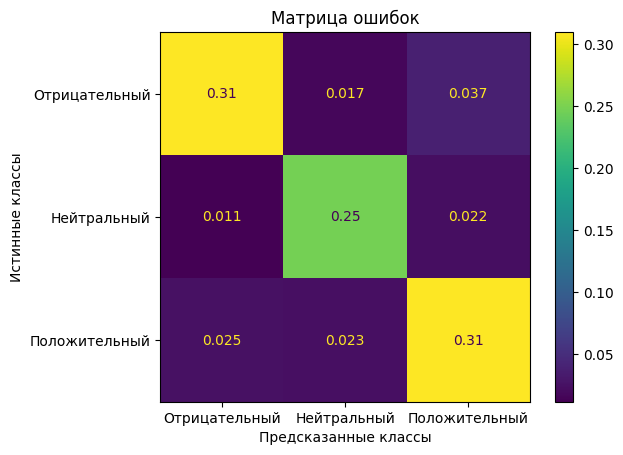

In [ ]:
ax= plt.subplot()
ConfusionMatrixDisplay.from_predictions(y_test, predicted_labels, normalize='all', display_labels=['Отрицательный', 'Нейтральный', 'Положительный'], ax=ax)
# labels, title and ticks
ax.set_xlabel('Предсказанные классы');ax.set_ylabel('Истинные классы'); 
ax.set_title('Матрица ошибок'); 
ax.xaxis.set_ticklabels(['Отрицательный', 'Нейтральный', 'Положительный']); ax.yaxis.set_ticklabels(['Отрицательный', 'Нейтральный', 'Положительный']);
plt.show()

In [ ]:
restored = load_model('/content/drive/MyDrive/Диплом/model5')

In [ ]:
# Evaluate the model on the test set
loss, accuracy, recall, precision, f1_score = restored.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

564/564 [==============================] - 4s 8ms/step - loss: 0.5525 - cat_accuracy: 0.8631 - recall: 0.8558 - precision: 0.8721 - f1-score: 0.8635
Test accuracy: 0.8630843162536621


In [ ]:
restored.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 300)          21000300  
                                                                 
 dropout (Dropout)           (None, 400, 300)          0         
                                                                 
 conv1d (Conv1D)             (None, 398, 400)          360400    
                                                                 
 global_max_pooling1d (Globa  (None, 400)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 400)               0         
                                                                 
 dense (Dense)               (None, 200)               80200     
                                                        

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Получение истории значений функции потерь и точности
history2 = history
loss_history = history2.history['loss']
val_accuracy_history = history2.history['val_cat_accuracy']
accuracy_history = history2.history['cat_accuracy']
val_recall_history = history2.history['val_recall']
recall_history = history2.history['recall']
val_precision_history = history2.history['val_precision']
precision_history = history2.history['precision']
val_f1score_history = history2.history['val_f1-score']
f1score_history = history2.history['f1-score']
# Создание массива шагов
epochs = range(1, len(loss_history) + 1)

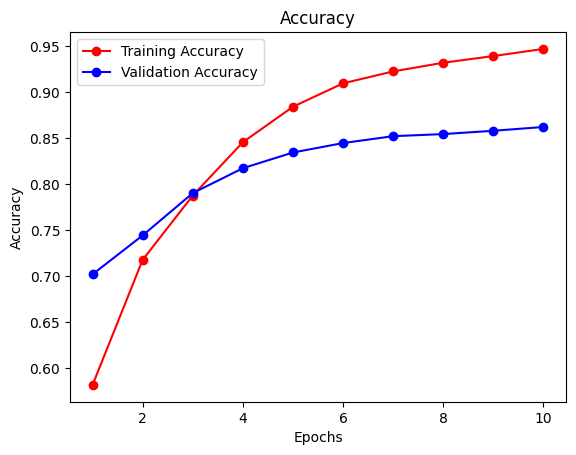

In [ ]:
# Построение графика изменения точности на валидационной выборке
plt.plot(epochs, accuracy_history, marker='o', color='r', label='Training Accuracy')
plt.plot(epochs, val_accuracy_history, marker='o', color='b', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

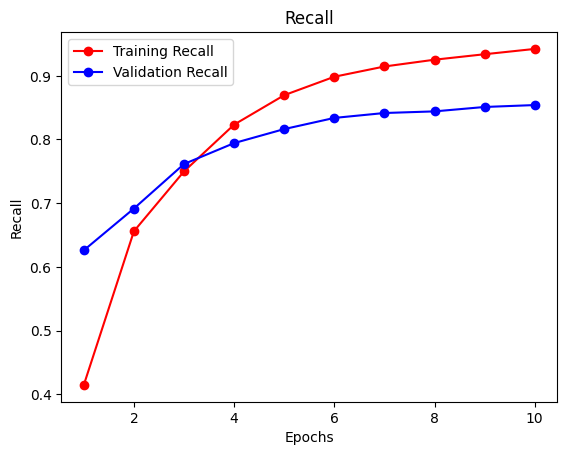

In [ ]:
# Построение графика изменения recall на обучающей выборке
plt.plot(epochs, recall_history, marker='o',  color='r', label='Training Recall')
plt.plot(epochs, val_recall_history, marker='o', color='b', label='Validation Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

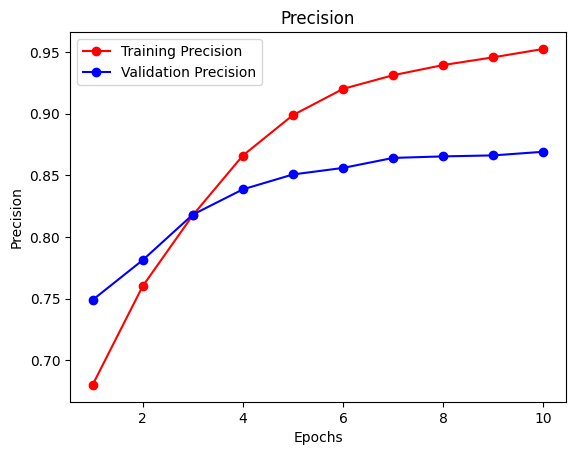

In [ ]:
# Построение графика изменения precision на обучающей выборке
plt.plot(epochs, precision_history, marker='o', color='r', label='Training Precision')
plt.plot(epochs, val_precision_history, marker='o', color='b', label='Validation Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

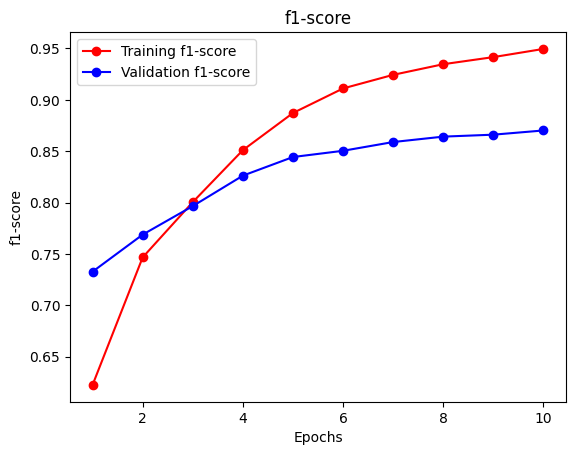

In [ ]:
# Построение графика изменения f1-score на обучающей выборке
plt.plot(epochs, f1score_history_np[:, 0], marker='o', color='r', label='Training f1-score')
plt.plot(epochs, val_f1score_history_np[:, 0], marker='o', color='b', label='Validation f1-score')
plt.title('f1-score')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()

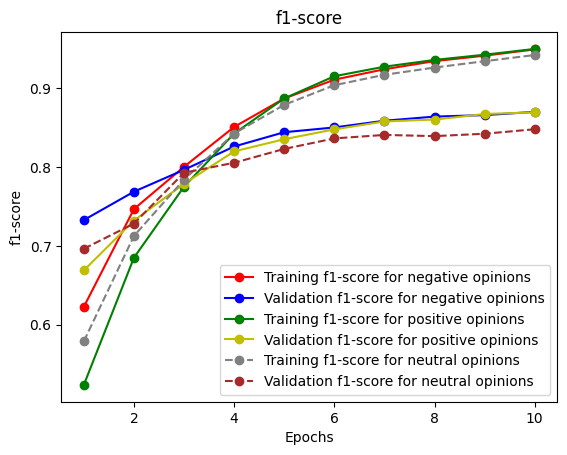

In [ ]:
# Построение графика изменения f1-score на обучающей выборке
plt.plot(epochs, f1score_history_np[:, 0], marker='o', color='r', label='Training f1-score for negative opinions')
plt.plot(epochs, val_f1score_history_np[:, 0], marker='o', color='b', label='Validation f1-score for negative opinions')
plt.plot(epochs, f1score_history_np[:, 1], marker='o', color='g', label='Training f1-score for positive opinions')
plt.plot(epochs, val_f1score_history_np[:, 1], marker='o', color='y', label='Validation f1-score for positive opinions')
plt.plot(epochs, f1score_history_np[:, 2], linestyle='dashed', marker='o', color='grey', label='Training f1-score for neutral opinions')
plt.plot(epochs, val_f1score_history_np[:, 2], linestyle='dashed', marker='o', color='brown', label='Validation f1-score for neutral opinions')
plt.title('f1-score')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()

In [ ]:
!pip install nlpaug

In [ ]:
import pandas as pd
import nlpaug.augmenter.word as naw
import nlpaug.flow as naf

In [ ]:
df.label.value_counts()

0    32886
2    32395
1    24883
Name: label, dtype: int64

In [ ]:
pd.Series(y_test).value_counts()

0    6547
2    6433
1    5053
Name: label, dtype: int64

In [ ]:
df.shape

(90164, 4)

In [ ]:
df1 = df[df.label == 1].sample(frac=0.041, ignore_index=True)
df1.shape

(1020, 4)

In [ ]:
df1 = df.sample(frac=0.1, ignore_index=True)
df1['label'].value_counts()

2    3278
0    3268
1    2470
Name: label, dtype: int64

In [ ]:
# Define the augmentation flow
flow = naf.Sequential([
    naw.RandomWordAug(action='delete', aug_p=0.1),
    naw.RandomWordAug(action='swap', aug_p=0.2)
])

# Define the function to apply augmentation to text data
def augment_text(text):
    return flow.augment(text)

In [ ]:
# Add a new column to the dataframe with augmented text
df['augmented_text'] = df['tweet_text'].apply(augment_text)